In [4]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import os
from os.path import join as pjoin
from matplotlib import pyplot as plt
import random
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,AveragePooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import average 
from keras.models import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import maximum_filter1d
from matplotlib.patches import Rectangle
import tensorflow as tf
warnings.filterwarnings('ignore')

ImportError: cannot import name 'img_as_float32'

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [3]:
# first we can see what does the feature look like
def get_raw_feature():
    video_data_dir='new23feature'
    X=[]
    Y=[]
    for video in os.listdir(video_data_dir):
        each_video= pjoin(video_data_dir,video)
        ## 'C:\\videofeature\\' using
#         l=each_video.split('t_')[1]

        # 'C:\\new_video_feature\\' using
        l=each_video.split('e_')[1]
        l=l.split('.')[0]
        LABEL=int(l)
        data_with_zero=np.load(each_video)
        data_with_zero=np.transpose(data_with_zero)
        for row in range(14):
            for col in range(data_with_zero.shape[1]):
                if data_with_zero[row,col] == 0 and col != 0:
                    data_with_zero[row,col] = data_with_zero[row,col-1] 
        data_with_zero=np.transpose(data_with_zero)
                
        
#         for col in range(data_with_zero.shape[1]):
#             for row in range(data_with_zero.shape[0]):  
#                 if data_with_zero[row,col] == 0 and row !=0 :
#                     data_with_zero[row,col] = 123#data_with_zero[row-1,col] 

        X.append(data_with_zero)
        Y.append(LABEL)
#     Video_label=pd.read_csv('label.csv')
# #     Video_label=np.array(Video_label)[:,:-1]
#     for i,value_x in enumerate(X):
#         if value_x == 0:
#             X[i] = X[i-1] if i != 0 else X[i+1]

#     for j,value_y in enumerate(Y):
#         if value_y == 0:
#             Y[j] = Y[j-1] if j != 0 else Y[j+1]
    return X,Y


## 1 Read features from 19 npy files

In [4]:
X,Y=get_raw_feature()
Video_label=pd.read_csv('newall_label.csv')
# Video_label=np.array(Video_label)[:,:-1]
print('there are ',len(X),'videos')
print('feature of video [0]',X[0].shape)
print('video [0] is from video' ,Y[0])
print(Y)

there are  23 videos
feature of video [0] (153, 14)
video [0] is from video 11
[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]


In [5]:
# X[3][2,0:22]

In [6]:
# a= np.sum(X[3]==0,axis=1)
# a

In [7]:
range_label=pd.read_csv('range_label.csv')
range_label.head()

,VideoNum,DP,BD,E,FS,A,RC
0,11,3,2,2,2,4,3
1,11,2,2,3,1,3,3
2,11,1,1,1,1,1,1
3,16,1,1,1,1,1,1
4,16,2,1,1,1,1,2


In [8]:
counts=range_label['VideoNum'].value_counts()
# counts

In [9]:
def get_review_times(videoNum):
    counts=range_label['VideoNum'].value_counts()
    times=int(counts[counts.index==videoNum])
    return times
get_review_times(192)

1

In [10]:
r_group=range_label.groupby(['VideoNum'])
r_max=r_group.max()
r_min=r_group.min()
r_max=r_max.reset_index()
r_min=r_min.reset_index()

In [11]:
def get_video_range(videoNum):
    vmax=r_max[r_max['VideoNum']==videoNum]
    vmin=r_min[r_min['VideoNum']==videoNum]
    return vmax,vmin

In [12]:
# a,i=get_video_range(11)

Video_label contains detail labels and we can use Y to index them later.

In [13]:
def getlabel(number):
    L=Video_label[Video_label['label']==number]
    L=np.array(L)[:,:-1]
    L= np.squeeze(L)
    return L
# def getlabel_addnoise(number):
#     L=Video_label[Video_label['label']==number]
#     L=np.array(L)[:,:-1]
#     L= np.squeeze(L)
#     noise=np.array([random.uniform(-0.4, 0.4) for _ in range(len(L))])
# #     print(noise)
#     return L+noise

Here we create two functions to sample video clips from each video and get their time differences.


In [14]:
def get_diff_and_hstack_to_orginal_data(X,time_lag=2,move_threshold=200):
    original=X[:-time_lag]
    modified=X[time_lag:]
    result=modified-original
    ## threshold
    # consider there was no top in the first image and it showed up in the next image
    # the difference would be huge, which was not ideal.
    # so we need to filter these extrem value 
    result[np.abs(result)>move_threshold]=0
    
    return np.hstack((X[time_lag:],result))

##from each video sample video clips with size=window_L. you can specify stride 
def make_video_clips(matrix,window_L,stride):
    alldata=[]

    total_frame=matrix.shape[0]
    index=[n for n in range(1,total_frame,stride)]
    for start_index in index:
        if start_index+window_L> total_frame:
            break
#         print(start_index)
        each_clip_data=matrix[start_index:start_index+window_L]
#         each_clip_data=np.transpose(each_clip_data)
#         print(each_clip_data.shape)
        alldata.append(each_clip_data)
    return np.array(alldata)

## 2 pre-processing the feature
make new 28-d feature and  sample video clips

In [15]:
####################################### set video clips parameters
############################################### make new 28-d feature
video_clips_length=30
time_lag=2
move_threshold=150
stride=video_clips_length

####################################### set video clips parameters
############################################### make new 28-d feature
all_data=[]
for each_video,label in zip(X,Y):

    re=get_diff_and_hstack_to_orginal_data(each_video,time_lag,move_threshold)
#     re=each_video
    video_clip=make_video_clips(re,video_clips_length,stride)
    print(video_clip.shape)
    all_data.append((video_clip))

def calculate_descriptor(x, y):
    #check if x and y are of the same length
    if x.shape != y.shape:
        print("x and y must be of the same length")
        return
    #create trajectory vector s = x + j*y
    trajectory = np.empty(x.shape, dtype=complex)
    trajectory.real = x
    trajectory.imag = y
    #fft

    fourier_transform = np.fft.fft(trajectory)
    return np.abs(fourier_transform)
    

fourier_data = []
for each_video,label in zip(X,Y):

    re=get_diff_and_hstack_to_orginal_data(each_video,time_lag,move_threshold)
    video_clip = make_video_clips(re,video_clips_length,stride)
    #print(video_clip.shape)
    temp = np.zeros(shape=(video_clip.shape[0], 30, 7))
    for i in range(video_clip.shape[0]):
        fourier_data.append
        temp[i,:,0] = calculate_descriptor(video_clip[i,:,0], video_clip[i,:,1])
        temp[i,:,1] = calculate_descriptor(video_clip[i,:,2], video_clip[i,:,3])
        temp[i,:,2] = calculate_descriptor(video_clip[i,:,4], video_clip[i,:,5])
        temp[i,:,3] = calculate_descriptor(video_clip[i,:,6], video_clip[i,:,7])
        temp[i,:,4] = calculate_descriptor(video_clip[i,:,8], video_clip[i,:,9])
        temp[i,:,5] = calculate_descriptor(video_clip[i,:,10], video_clip[i,:,11])
        temp[i,:,6] = calculate_descriptor(video_clip[i,:,12], video_clip[i,:,13])
        #print(video_clip[i,:,0:2].shape)
    fourier_data.append(temp)
    #print(len(all_data))
    print(temp.shape)
    print(len(fourier_data))

(5, 30, 28)
(4, 30, 28)
(10, 30, 28)
(20, 30, 28)
(10, 30, 28)
(100, 30, 28)
(40, 30, 28)
(19, 30, 28)
(100, 30, 28)
(5, 30, 28)
(100, 30, 28)
(10, 30, 28)
(10, 30, 28)
(5, 30, 28)
(20, 30, 28)
(40, 30, 28)
(99, 30, 28)
(9, 30, 28)
(20, 30, 28)
(40, 30, 28)
(20, 30, 28)
(10, 30, 28)
(10, 30, 28)
(5, 30, 7)
1
(4, 30, 7)
2
(10, 30, 7)
3
(20, 30, 7)
4
(10, 30, 7)
5
(100, 30, 7)
6
(40, 30, 7)
7
(19, 30, 7)
8
(100, 30, 7)
9
(5, 30, 7)
10
(100, 30, 7)
11
(10, 30, 7)
12
(10, 30, 7)
13
(5, 30, 7)
14
(20, 30, 7)
15
(40, 30, 7)
16
(99, 30, 7)
17
(9, 30, 7)
18
(20, 30, 7)
19
(40, 30, 7)
20
(20, 30, 7)
21
(10, 30, 7)
22
(10, 30, 7)
23


So there are 19 videos and you can see how many video clips they have.

And next we will use leave one method to train the model.

## 3 prepare leave one data and give every video clips their label

In [16]:
# this function is used to stack 18 videos into a big matrix
# the dimenstion will be 
# (n1+n2..+n18,28,30)
# and the label will be (n1+n2..+n18,6)

def stack_video_clips_get_label(data,data2,label):
    final_data=data[0]
    
    final_f=data2[0]

    final_label=[getlabel(label[0]) for _ in range(final_data.shape[0])]
#     print(len(final_label))
#     print(final_data.shape)
    for i in range(1,len(data)):
        final_data=np.vstack((final_data,data[i]))
        final_f=np.vstack((final_f,data2[i]))
        
        for j in range(data[i].shape[0]):
            final_label.append(getlabel(label[i]))
    return final_data,final_f,np.array(final_label)

########## leave one and stack all video clips
def hold_out(X,F,Y,hold_number):
        new_label=Y.copy()
        new_data=X.copy()
        new_f=F.copy()
        # find video n 's index
        index=new_label.index(hold_number)
        # get the video n and it's label
        X_test=new_data[index]
        F_test=new_f[index]
        test_label=getlabel(hold_number)
        y_test=np.array([test_label for _ in range(X_test.shape[0])])
#         # so we can del them 
        del new_label[index]
        del new_data[index]
        del new_f[index]
#         print(new_label)
        final_data_X,final_data_F,final_data_Y=stack_video_clips_get_label(new_data,new_f,new_label)

        return final_data_X,X_test,final_data_Y,y_test,final_data_F,F_test

In [17]:
# for each col, calculate the weighted average
def get_weighted_average(df):
    length=len(df)
    top=int(1/6*length)
    bottom=length-top
    df=np.array(df)
    df=np.sort(df)
    weghted_sum=np.sum(df[:top]*(1/6))+np.sum(df[top+1:bottom]*(2/3))+np.sum(df[bottom+1:]*(1/6))
    weghted_sum=weghted_sum/length
    return weghted_sum

# make the data frame
# Plot_data is the pridect result, which will have 6 scores
def get_video_score(Plot_data,GT,poolingweight):
    weight_ave_re=[]
    mean_re=[]
    median_re=[]
    pooled_re=[]
    
    for i in Plot_data.columns:
        weight_ave=get_weighted_average(Plot_data[i])
        weight_ave_re.append(weight_ave)
        
        mean_value=np.mean(Plot_data[i])   
        mean_re.append(mean_value)
        
        median_value = np.median(Plot_data[i])
        median_re.append(median_value)
        
        weight_ave_wight=poolingweight[0]
        mean_value_wight=poolingweight[1]
        median_value_wight=poolingweight[2]
        # pooling is also a weighted average 
        pooling = (weight_ave*weight_ave_wight + mean_value*mean_value_wight + median_value*median_value_wight)
        pooled_re.append(pooling)
        
    video_result=pd.DataFrame([weight_ave_re,mean_re,median_re,pooled_re,GT])
    video_result.columns = ['DP','BD','E','FS','A','RC']
    video_result.index = ['Weighted_average', 'Mean', 'Median','Cool_pooling','Ground_truth']
    return video_result

## 3 perform leave one cross validation  


In [18]:
from keras.layers import average, concatenate,RepeatVector,Lambda,add,subtract,Activation
from keras.models import Input, Model
from keras import backend as K
from keras.layers.normalization import BatchNormalization

In [19]:
# the model we will use
def make_model_1d(l2_lambda,clip_lenth,dimension,ss):
    input_holder = Input(shape=(clip_lenth, dimension))
    fourier_descriptor_input = Input(shape=(clip_lenth, 7), name="fourier_descriptor")
    x = Conv1D(filters=8, 
                     kernel_size=15, 
                     strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(input_holder)
    x = BatchNormalization()(x)

    x = Conv1D(filters=8, 
                     kernel_size=10, 
               strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
#     x = Conv1D(filters=8, 
#                      kernel_size=5, 
#                      padding='same',
#                      activation='relu', 
#                      input_shape=(clip_lenth, dimension),
#                      kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x= MaxPooling1D(2,padding='same')(x)
    
    x = Conv1D(filters=16, 
                     kernel_size=5, 
               strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=16, 
                     kernel_size=5, 
               strides=ss,
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)
#     x = Conv1D(filters=16, 
#                      kernel_size=5, 
#                      padding='same',
#                      activation='relu', 
#                      input_shape=(clip_lenth, dimension),
#                      kernel_regularizer=l2(l2_lambda))(x)

#     x = GlobalMaxPooling1D()(x)
#     x = Flatten()(x)

#####_______________________________________________________________________
    u = GlobalMaxPooling1D()(x)
    u_broadcast=RepeatVector(x.shape[1])(u)
    
    def op(inputs):
        x, y = inputs
        return K.pow((x - y), 2) 

    Z=Lambda(op)([u_broadcast,x])

    v = GlobalMaxPooling1D()(Z)
    new_x= Flatten()(fourier_descriptor_input)
    new_x = Dense(32, 
              activation='relu',
              kernel_initializer='he_uniform',

            )(new_x)
    x = concatenate([u,v,new_x])
    
    
#####_______________________________________________________________________
#     x = Dense(16, 
#               activation='relu',
#               kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#             )(x)

#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers
    
#     x = Dense(6, 
#               activation='sigmoid', 
#               kernel_initializer='glorot_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
    
#####_______________________________________________________________________  
#     x = Dense(16,activation='relu',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers


#     x = Dense(32,activation='relu',kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers

#####______________________________Multi task_________________________________________  
# ['DP','BD','E','FS','A','RC']
    number_of_N=16
    DP=0.2
    
    y1 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Dropout(DP)(y1) # add some dropout for regularization after conv layers
    y1= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='DP'
#              kernel_regularizer=l2(l2_lambda)
             )(y1)

    y2 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = Dropout(DP)(y2) # add some dropout for regularization after conv layers
    y2= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='BD'
#              kernel_regularizer=l2(l2_lambda)
             )(y2)
    
    y3 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)
    y3 = Dropout(DP)(y3) # add some dropout for regularization after conv layers
    y3= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='E'
#              kernel_regularizer=l2(l2_lambda)
             )(y3)

    y4 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)
    y4 = Dropout(DP)(y4) # add some dropout for regularization after conv layers
    y4= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='FS'
#              kernel_regularizer=l2(l2_lambda)
             )(y4)
    
    y5 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)
    y5 = Dropout(DP)(y5) # add some dropout for regularization after conv layers
    y5= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='A'
#              kernel_regularizer=l2(l2_lambda)
             )(y5)
    
    y6 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y6 = BatchNormalization()(y6)
    y6 = Activation('relu')(y6)
    y6 = Dropout(DP)(y6) # add some dropout for regularization after conv layers
    y6= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='RC'
#              kernel_regularizer=l2(l2_lambda)
             )(y6)
#####______________________________Multi task_________________________________________  

    all_input = [input_holder, fourier_descriptor_input]
    model = Model(inputs=all_input,outputs=[y1,y2,y3,y4,y5,y6])
# ['DP','BD','E','FS','A','RC']
    losses = {
        "DP": "mean_squared_error",
        "BD": "mean_squared_error",
        "E": "mean_squared_error",
        "FS": "mean_squared_error",
        "A": "mean_squared_error",
        "RC": "mean_squared_error",
    }
    model.compile(#loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error' 'mean_absolute_percentage_error'
                  loss=losses, 
              optimizer='adam') # 'adadelta' 'rmsprop'                  
#     model.summary()
    return model
te=make_model_1d(0.001,30,28,2)

In [20]:
# from IPython.display import SVG
# from keras.utils import plot_model
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(te).create(prog='dot', format='svg'))

In [21]:
te.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 28)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 8)        3368        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 15, 8)        32          conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8, 8)         648         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [22]:
# plot_model(te, to_file='model1.png')

In [33]:
# c=np.random.randn(6000,3000)*(0.1**0.5)
# np.std(c)**2

In [34]:
# customized data generator
def generator_noise(data1, data2, label, batch_size=64,noise_range=0.1):
    while 1:
        DP = []  
        BD = []
        E = []
        FS = []
        A = []
        RC = []
        rows = np.random.randint(0, data1.shape[0], size=batch_size)

        samples1 = data1[rows]
        samples2 = data2[rows]
        y=label[rows]
        noise=np.random.randn(y.shape[0],y.shape[1])
        y=y+noise*(0.1**0.5)
        for i in range(len(y)):
            DP.append(y[i][0])
            BD.append(y[i][1])
            E.append(y[i][2])
            FS.append(y[i][3])
            A.append(y[i][4])
            RC.append(y[i][5])
        labels = [np.array(DP),np.array(BD),np.array(E),np.array(FS), np.array(A),np.array(RC)]
        yield [samples1, samples2],labels
        
def generator(data1,data2, label, batch_size=64):
    while 1:
        DP = []  
        BD = []
        E = []
        FS = []
        A = []
        RC = []
        rows = np.random.randint(0, data1.shape[0], size=batch_size)

        samples1 = data1[rows]
        samples2 = data2[rows]
        y=label[rows]
#         noise=np.random.uniform(low=-0.5, high=0.5, size=(y.shape[0],y.shape[1]))
#         y=y+noise
        for i in range(len(y)):
            DP.append(y[i][0])
            BD.append(y[i][1])
            E.append(y[i][2])
            FS.append(y[i][3])
            A.append(y[i][4])
            RC.append(y[i][5])
        labels = [np.array(DP),np.array(BD),np.array(E),np.array(FS), np.array(A),np.array(RC)]
        yield [samples1, samples2],labels

In [35]:
def test_hold_out(model_name,hold_out_number,E,show_result=False,l2lambd=0.001,noise_range=0.1,poolingweight=[0.2,0.4,0.4],stride=1):
    # using leave one cv to get train/test data
    X_train, X_test, y_train, y_test,F_train, F_test=hold_out(all_data,fourier_data,Y,hold_out_number)
    
    # scale all the value to 0-1
    X_train=X_train/640-0.5
    X_test=X_test/640-0.5
    y_train=y_train/5
    y_test=y_test/5
#     y_train=y_train
#     y_test=y_test
    # print(X_train.shape,y_train.shape)
    # print(X_test.shape,y_test.shape)

    sample_of_trainningdata=X_train.shape[0]
    sample_of_testdata=X_test.shape[0]

    batch_size=128

    train_gen=generator_noise(X_train,F_train, y_train, batch_size,noise_range)
    val_gen=generator(X_test, F_test,y_test, batch_size)
    
    #prepare for inout shape
    clip_lenth=X_train.shape[1]
    dimension=X_train.shape[2]
    
    if model_name=='CNN':    
        model=make_model_1d(l2lambd,clip_lenth,dimension,stride)
    if model_name =='CNN3':
        model=make_model_1d_3layer(l2lambd,clip_lenth,dimension)
        
    model_h=model.fit_generator(train_gen,
                        steps_per_epoch=sample_of_trainningdata//batch_size,
                        epochs=E,
                        validation_data=val_gen,
                       validation_steps=sample_of_testdata//batch_size +1 ,
                        verbose=0 )
  
    GT=list(getlabel(hold_out_number))

    #get pridect result
    predict=model.predict([X_test,F_test])
    data={}
    task=['DP','BD','E','FS','A','RC']

    for i in range(len(predict)):
        data[task[i]]=np.squeeze(predict[i])

#         Plot_data=pd.DataFrame(predict,columns=['DP','BD','E','FS','A','RC'])
    Plot_data=pd.DataFrame(data)
    Plot_data=Plot_data*5
    filtered_data=Plot_data.copy()
    for index, row in filtered_data.iteritems():
#         filtered_data[index]=gaussian_filter1d(filtered_data[index], 0.6)
        filtered_data[index]=maximum_filter1d(filtered_data[index],mode='nearest',size= 5)
#         maximum_filter1d([2, 8, 0, 4, 1, 9, 9, 0], size=3)

    video_result=get_video_score(Plot_data,GT,poolingweight)
    gt=video_result.iloc[4]
    re=video_result.iloc[3]
    each_diff=np.abs(re-gt)
    
    filtered_video_result=get_video_score(filtered_data,GT,poolingweight)
    fi_re=filtered_video_result.iloc[3]
    fi_each_diff=np.abs(fi_re-gt)
    
    if show_result:
        ax=plt.figure(figsize=(12,14))
        ax = plt.subplot(421)
        ax.plot(model_h.history['loss'])
        plt.ylabel('Training Loss')
        plt.xlabel('epochs')

        ax = plt.subplot(422)
        ax.plot(model_h.history['val_loss'])
        plt.ylabel('valadation Loss')
        plt.xlabel('epochs')
#         print('loss',model_h.history['val_loss'][-1])
    
        y=[x for x in range(1,7)]
        ax = plt.subplot(423)
        Plot_data.plot.box(ax=ax)
        ax.plot(y, re, label='predict')
        ax.plot(y, gt, label='ground truth')

        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        ax.legend()

        ax = plt.subplot(424)
        Plot_data.plot(ax=ax)
#         ax.plot(Plot_data)
        ax.legend(['DP','BD','E','FS','A','RC'],bbox_to_anchor=(1,1))
#         ax.plot(Plot_data.BD)
        plt.ylabel('Gear Score')
        plt.xlabel('Video clips length')
        
        
        ax = plt.subplot(425)
        filtered_data.plot.box(ax=ax)
        ax.plot(y, fi_re, label='predict')
        ax.plot(y, gt, label='ground truth')
        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        ax.legend()
 
        ax = plt.subplot(426)
        filtered_data.plot(ax=ax)
#         ax.plot(Plot_data)
        ax.legend(['DP','BD','E','FS','A','RC'],bbox_to_anchor=(1,1))
#         ax.plot(Plot_data.BD)
        plt.ylabel('Gear Score')
        plt.xlabel('Video clips length')


        ax = plt.subplot(427)
        times=get_review_times(hold_out_number)
        ax.plot(y, np.round(re), label='predict-round')
        ax.plot(y, re, label='predict')
        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        
        if times>1:        
            vmax,vmin=get_video_range(hold_out_number)

            it=1
            for types in ['DP','BD','E','FS','A','RC']:
                Range=vmax[types]-vmin[types]
                rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
                ax.add_patch(rect)   
                it=it+1
        else:
#             new_re=np.round(video_result.iloc[3])
#             ax.plot(y, new_re, label='predict-round')
            ax.plot(y, gt, label='ground truth')        
        labels=['','DP','BD','E','FS','A','RC']
        ax.set_xticklabels(labels)
        ax.legend()
        
        ax = plt.subplot(428)
        times=get_review_times(hold_out_number)
        ax.plot(y, np.round(fi_re), label='predict-round')
        ax.plot(y, fi_re, label='predict')
        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        
        if times>1:        
            vmax,vmin=get_video_range(hold_out_number)

            it=1
            for types in ['DP','BD','E','FS','A','RC']:
                Range=vmax[types]-vmin[types]
                rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
                ax.add_patch(rect)   
                it=it+1
        else:
#             new_re=np.round(video_result.iloc[3])
#             ax.plot(y, new_re, label='predict-round')
            ax.plot(y, gt, label='ground truth')        
        labels=['','DP','BD','E','FS','A','RC']
        ax.set_xticklabels(labels)
        ax.legend()        

#         plt.savefig(str(hold_out_number)+'result.png')
        plt.show()
        
    return model_h.history['val_loss'][-1],list(each_diff),list(fi_each_diff)


In [36]:
print(Y)

[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]


In [37]:
def get_swarm_data(Diff_plot):
    name=['DP','BD','E','FS','A','RC']
    err=[]
    typen=[]
    for n in name:
        for record in Diff_plot[n]:
            err.append(record)
            typen.append(n)

    swarm_data = {'err': err, 'score_type':typen}
    swarm_data = pd.DataFrame(data=swarm_data)
    return swarm_data


In [38]:
def model_slection(model_name,E,l2lam,noise_range,poolingweight):  
    Diff_plot=[]
#     E=20
#     l2lam=0.01
#     noise_range=0.1
    show_result=False

    total_loss=0
    
#     for i in [11, 113, 130, 143]:
    for i in Y:
        print('video',i,end=' ')
        loss,each_diff=test_hold_out(model_name,i,E,show_result,l2lam,noise_range,poolingweight)
        total_loss=total_loss+loss
        Diff_plot.append(each_diff)

    ax=plt.figure(figsize=(16,5))
    
    Diff_plot=np.array(Diff_plot)
    Diff_plot=pd.DataFrame(Diff_plot)
    Diff_plot.columns = ['DP','BD','E','FS','A','RC']
    ax = plt.subplot(131)
    Diff_plot.plot.box(ax=ax)
    plt.ylim(0,4.5)
    print('total_loss= ',total_loss)
    

    bx = plt.subplot(132)
    swarm_data=get_swarm_data(Diff_plot)
    bx = sns.swarmplot(x="score_type", y="err", data=swarm_data,color="0.2")
    ax = sns.boxplot(x="score_type", y="err", data=swarm_data)
    plt.ylim(0,4.5)

    
    cx = plt.subplot(133)
    cx = sns.violinplot(x="score_type", y="err", data=swarm_data)
    plt.ylim(0,4.5)
    plt.show()
    
    print('all gear score abs error',np.sum(np.sum(Diff_plot)))
    print('each gear score abs error\n',np.sum(Diff_plot))
    weight=''
    for i in poolingweight:
        weight+=str(i)+'_'
        
    out_name='data//'+str(E)+'_'+str(l2lam)+'_'+str(noise_range)+'_'+str(weight)+'.npy'
    np.save(out_name,Diff_plot)

In [39]:
# show_result=True
# E=15
# model_name='CNN'
# l2lam=0.0001
# noise_range=0.1
# poolingweight=[0,1,0]
# loss,each_diff,fi_each_diff=test_hold_out(model_name,143,E,show_result,l2lam,noise_range,poolingweight)

In [40]:

# PLOTDATA.plot()

In [41]:
# test=PLOTDATA.copy()
# for index, row in test.iteritems():
#     test[index]=gaussian_filter1d(test[index], 1)
# test.plot()
# model_slection(10,0.0005,0.2,[0.333333,0.333333,0.333333])

video 11 

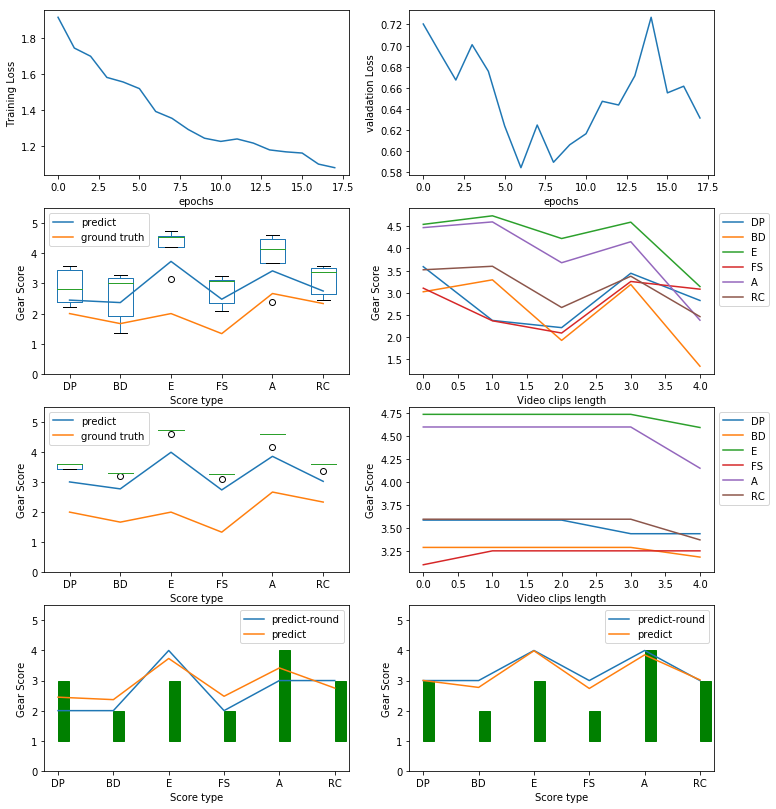

5.194628273748494 7.378621606847906
video 113 

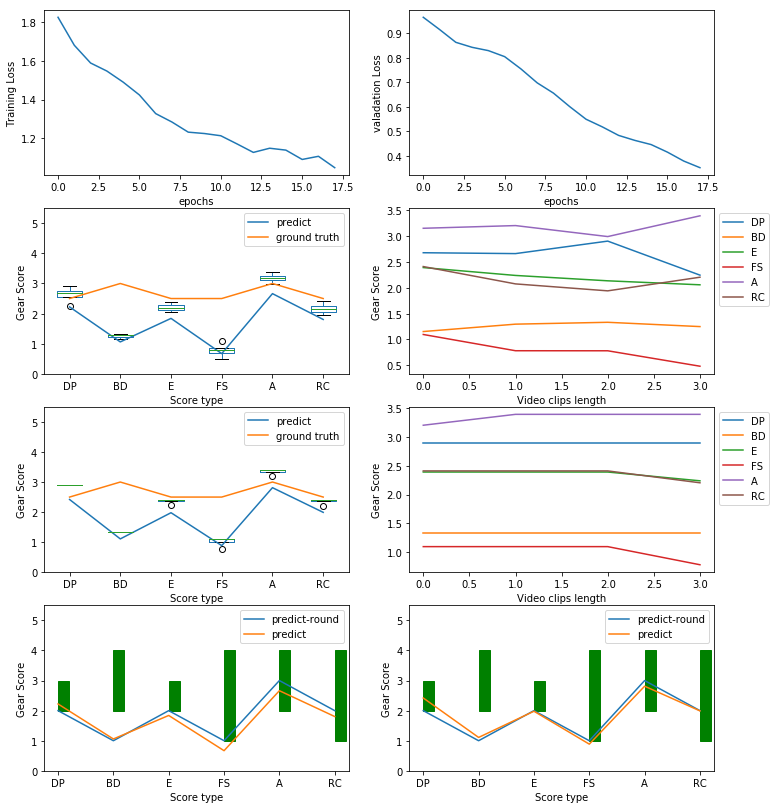

5.744646890348971 4.800788952416421
video 130 

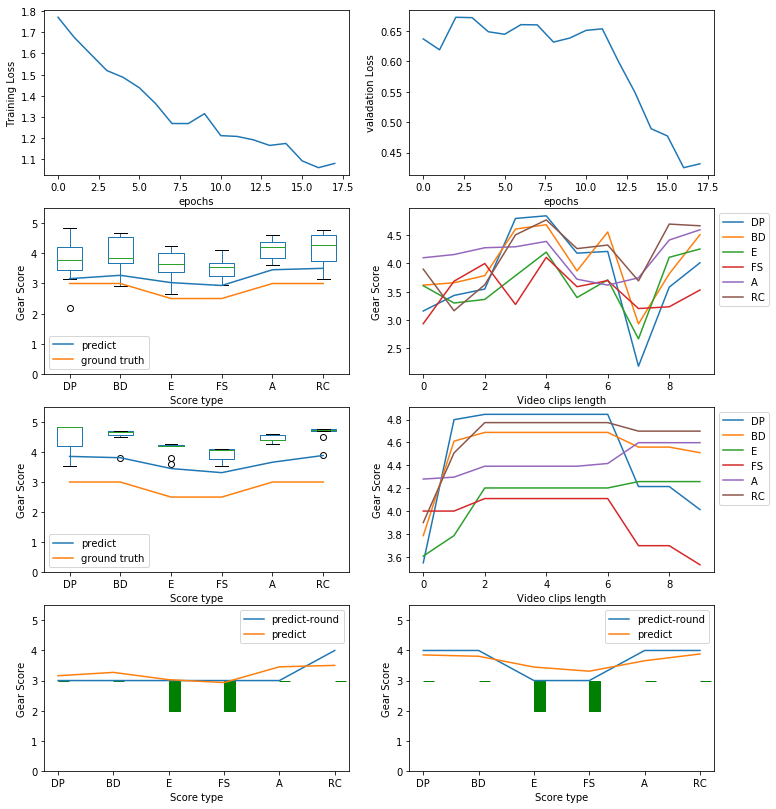

2.3553233983854764 4.962086570479155
video 143 

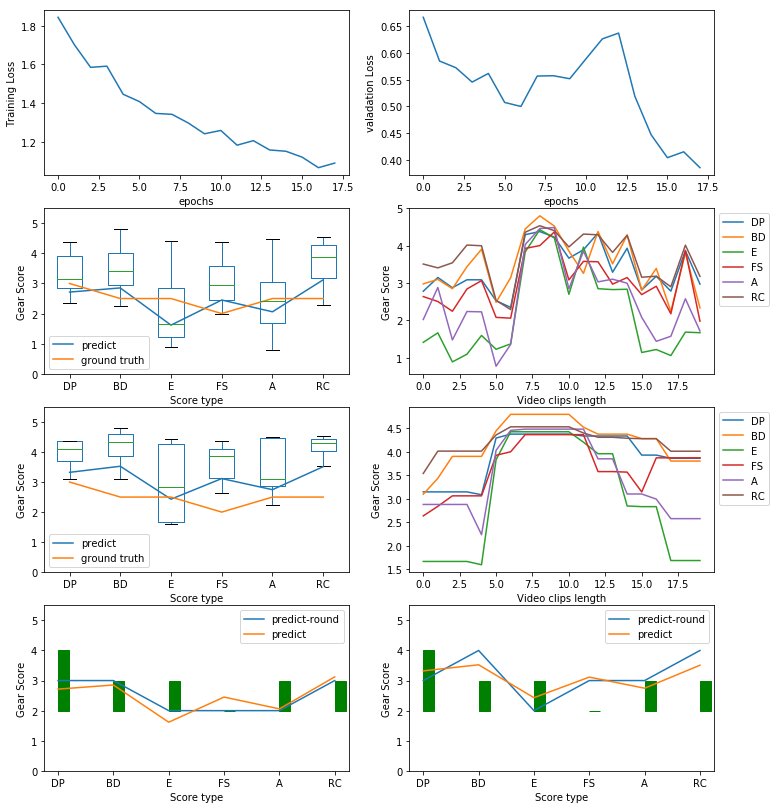

3.0365323443783994 3.7865567465461254
video 152 

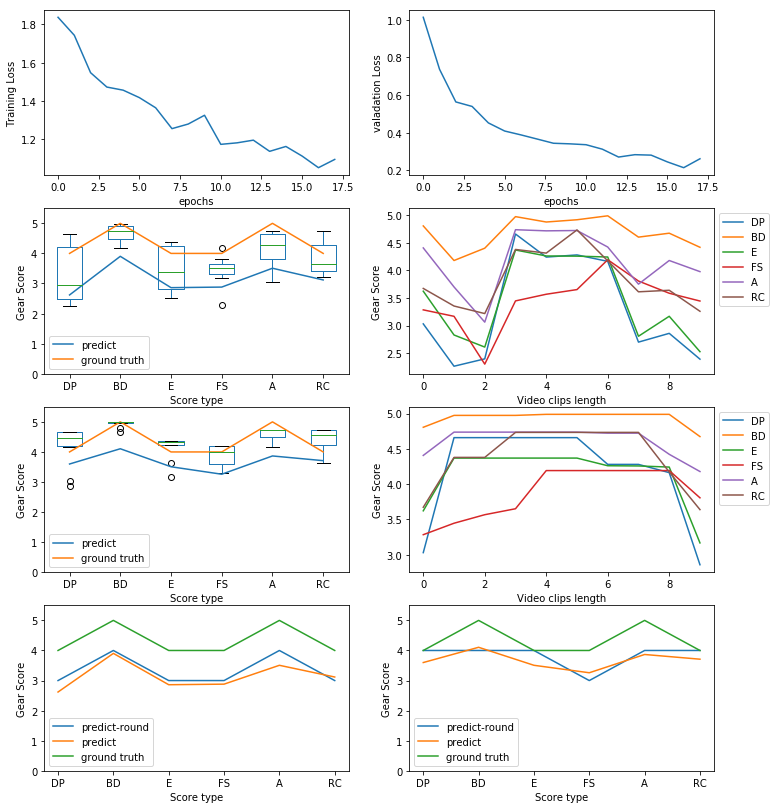

7.110479123228122 3.9509026242994785
video 16 

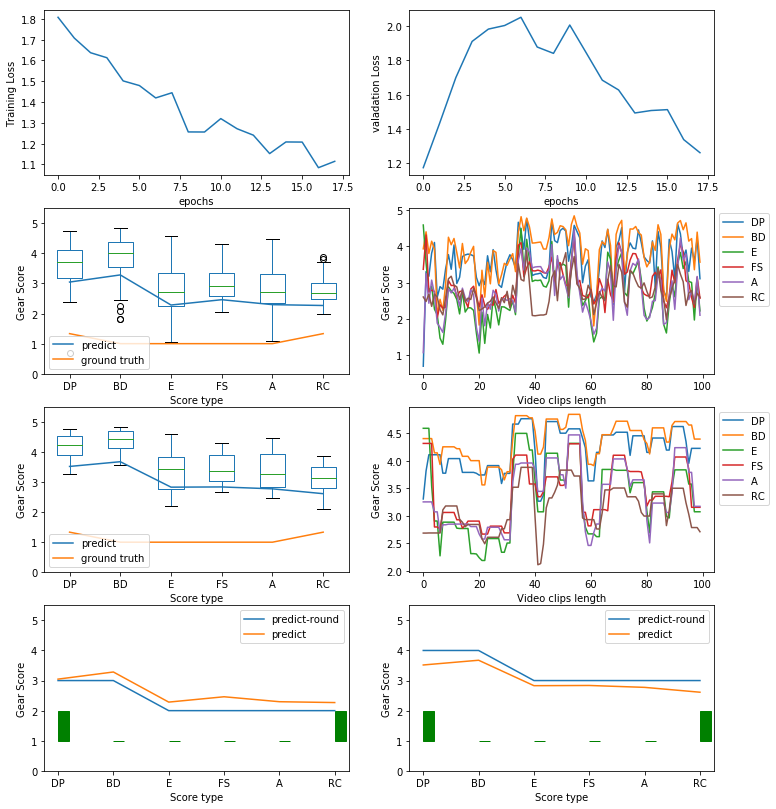

8.976243354068721 11.578814330647567
video 164 

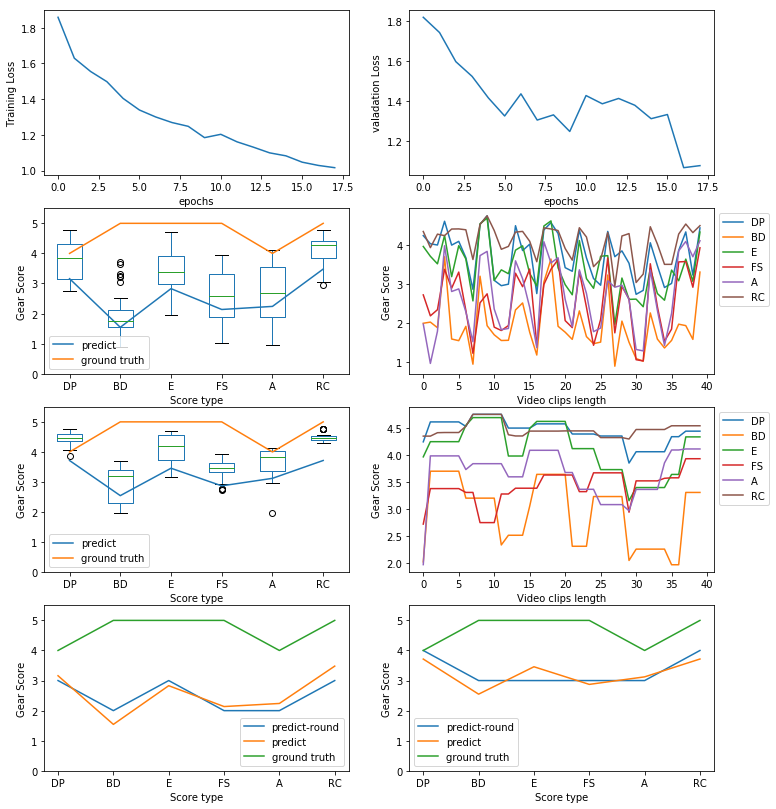

12.612883378261566 8.56656652525487
video 171 

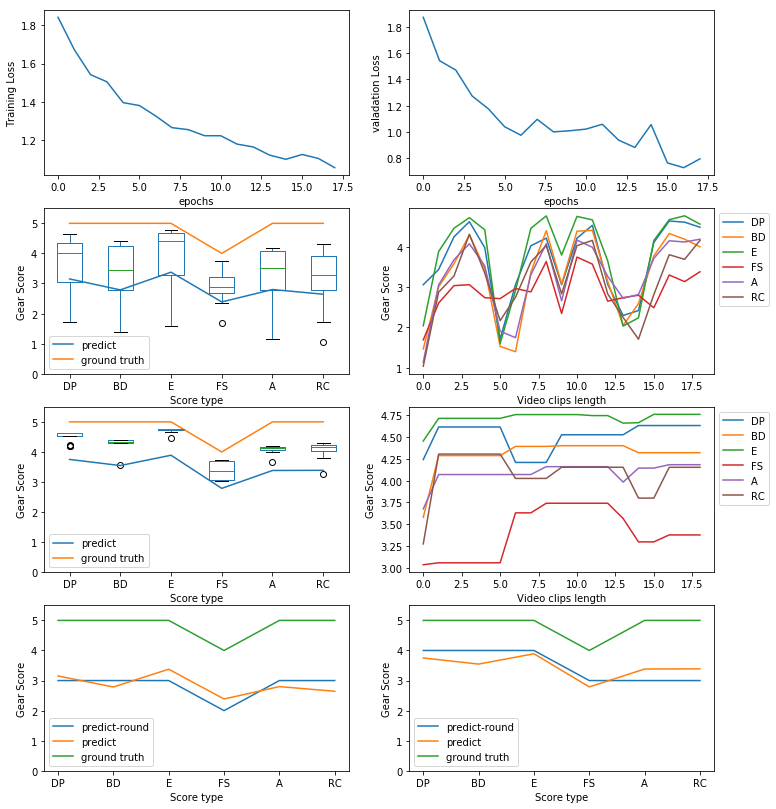

11.85447121116997 8.249139810962289
video 176 

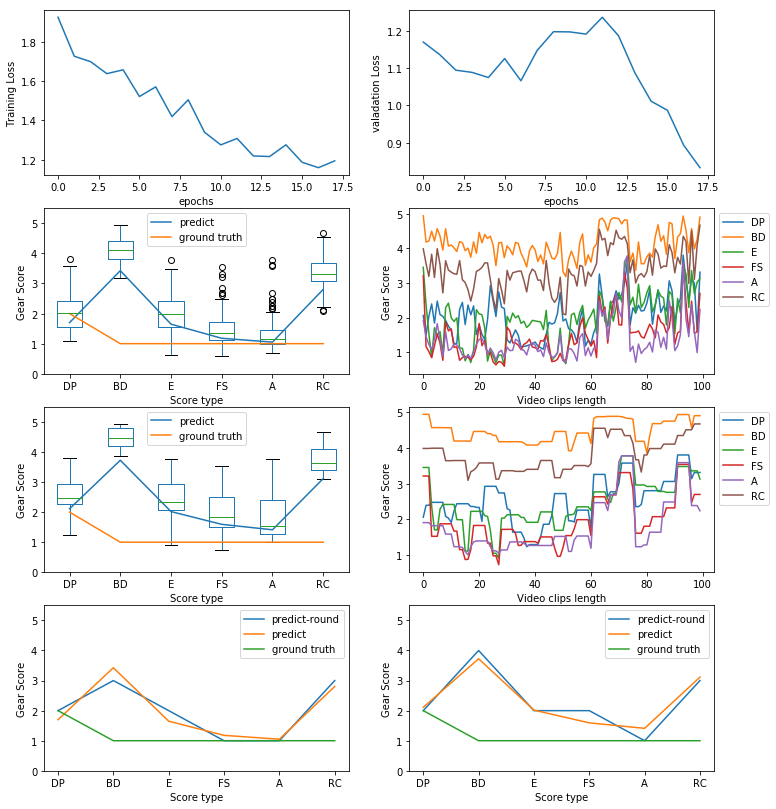

5.407515501091204 6.971407019205027
video 192 

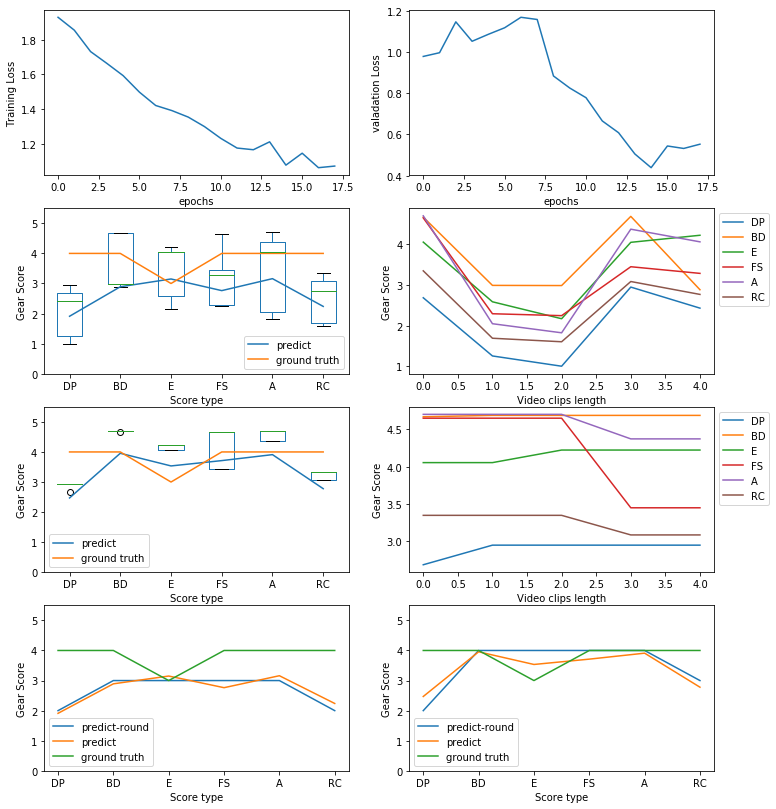

7.185707274477101 3.7064816849500652
video 194 

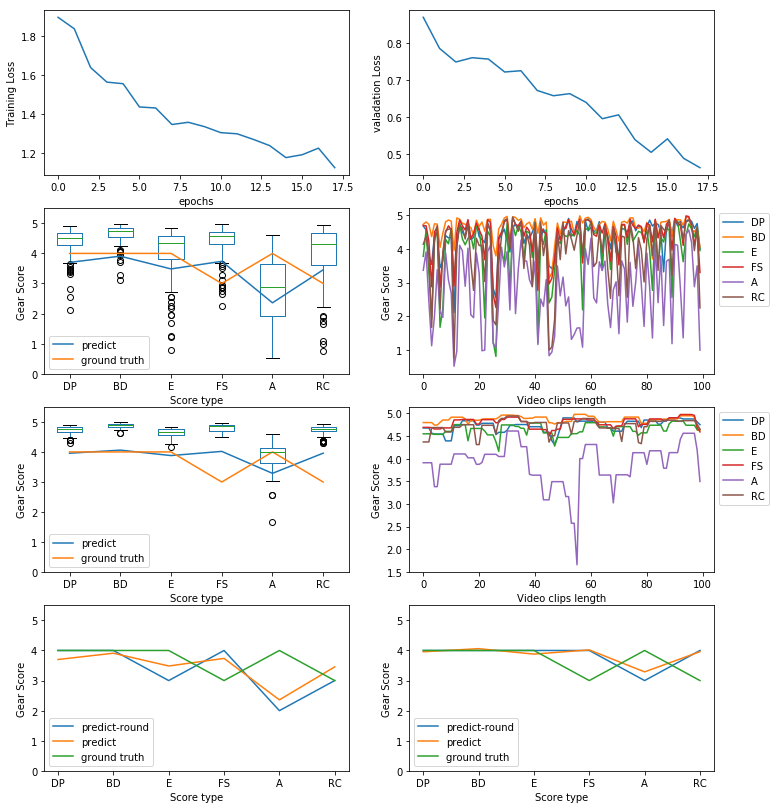

3.7400289987518787 2.913850735114821
video 207 

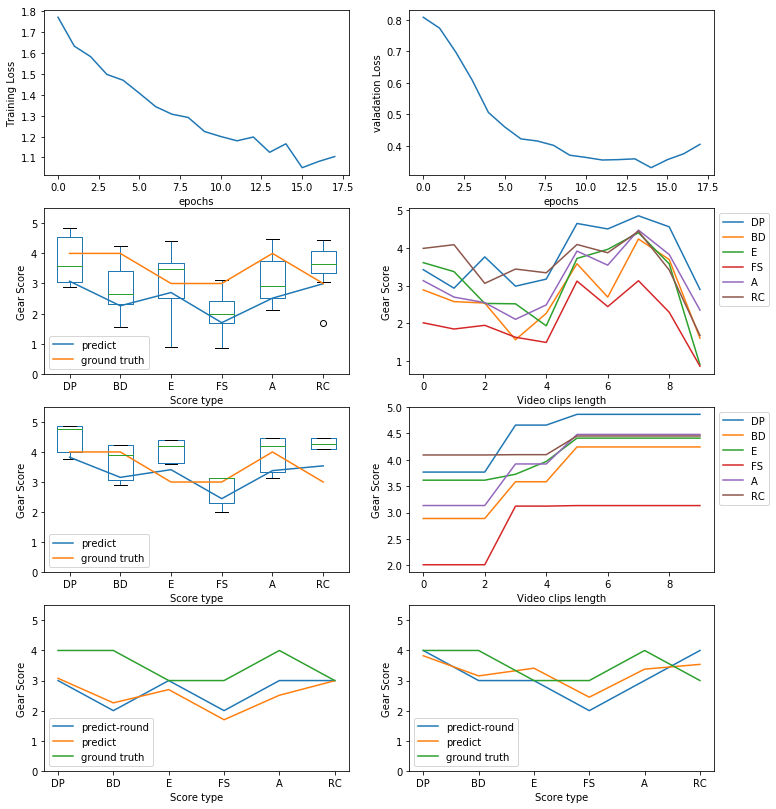

5.763331017641759 3.143175037382985
video 236 

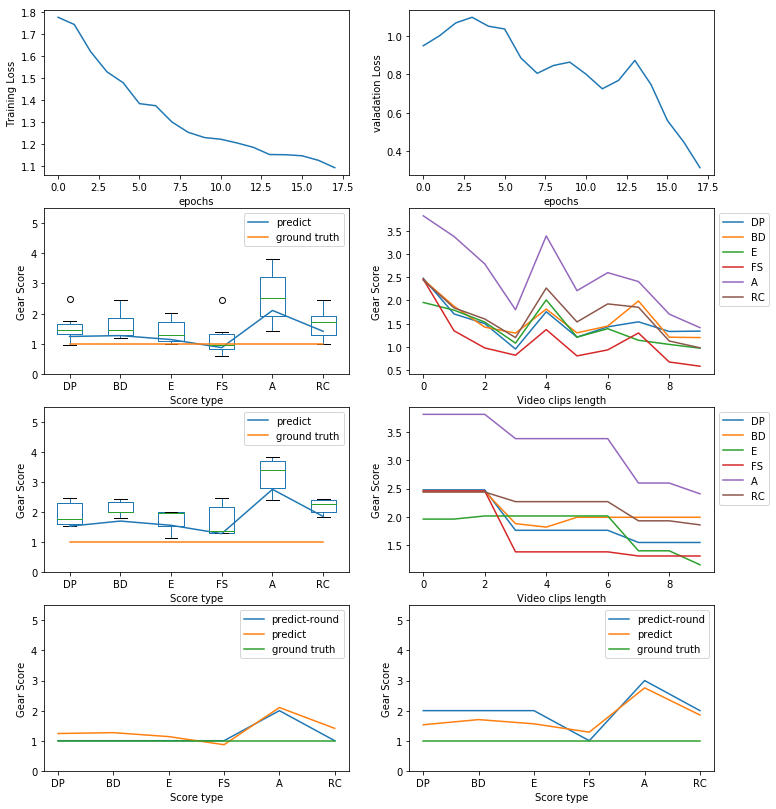

2.290512064851213 4.690424742952322
video 237 

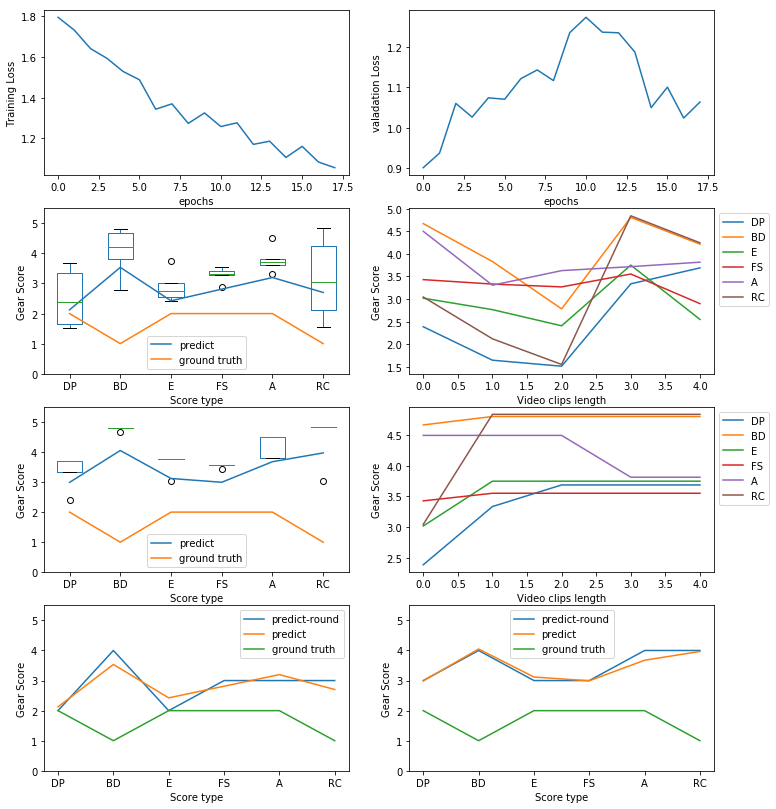

6.79801071738386 10.789514287877846
video 240 

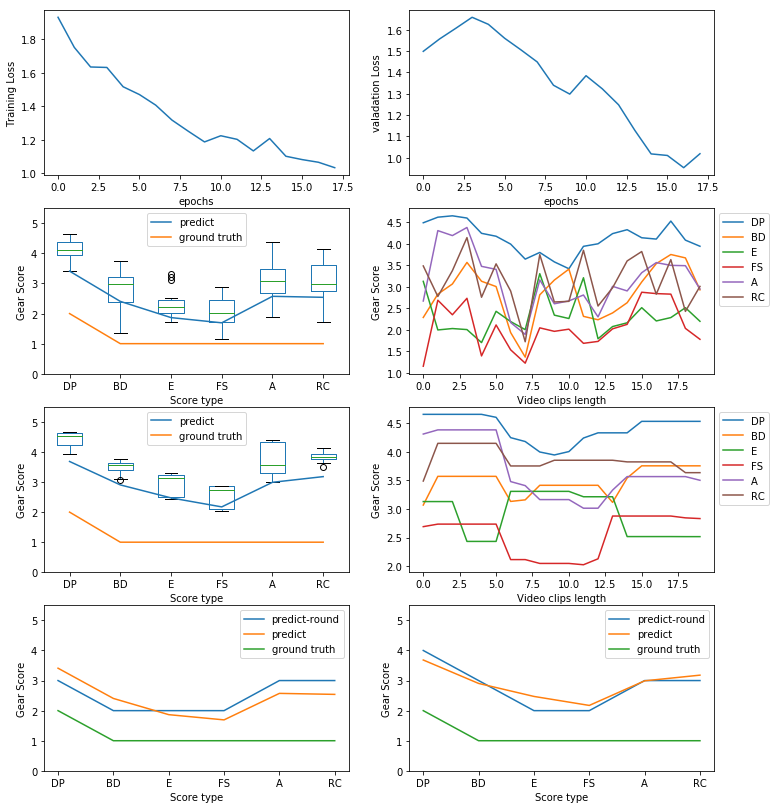

7.489594529352569 10.404396550002957
video 253 

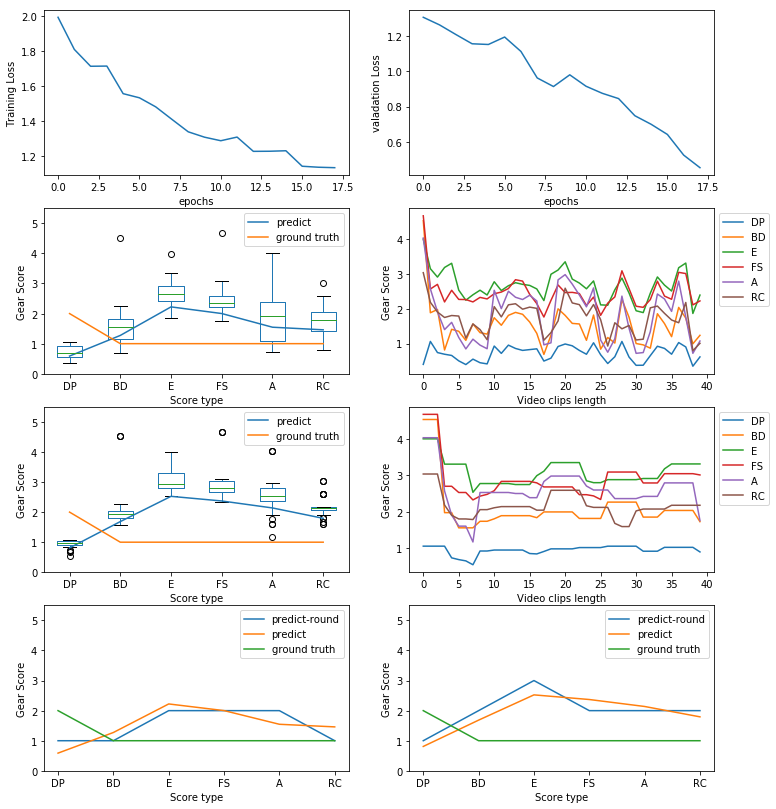

4.916056445666849 6.7008544870121955
video 257 

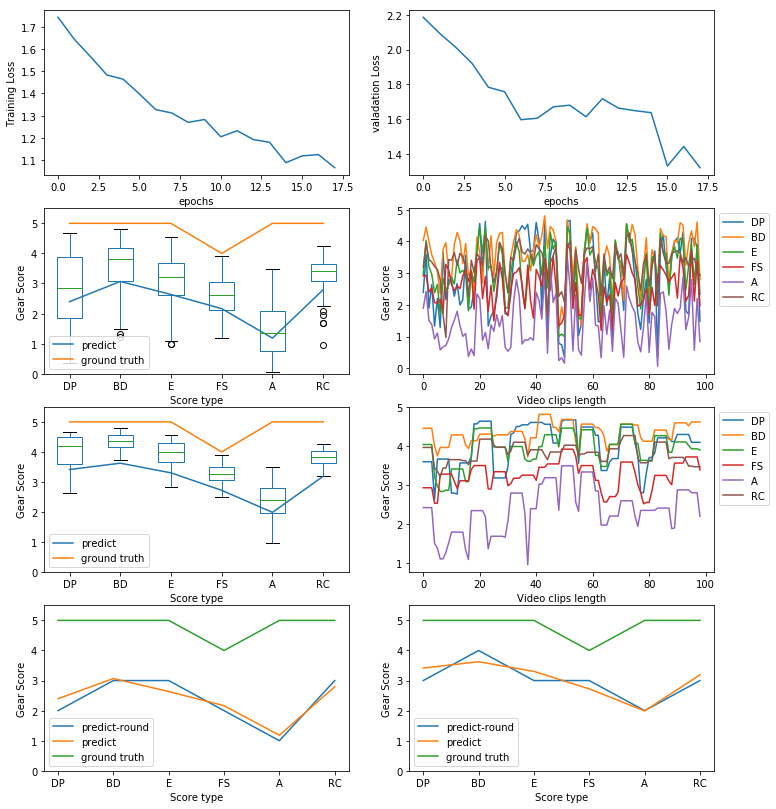

14.760362742687226 10.74863618062234
video 258 

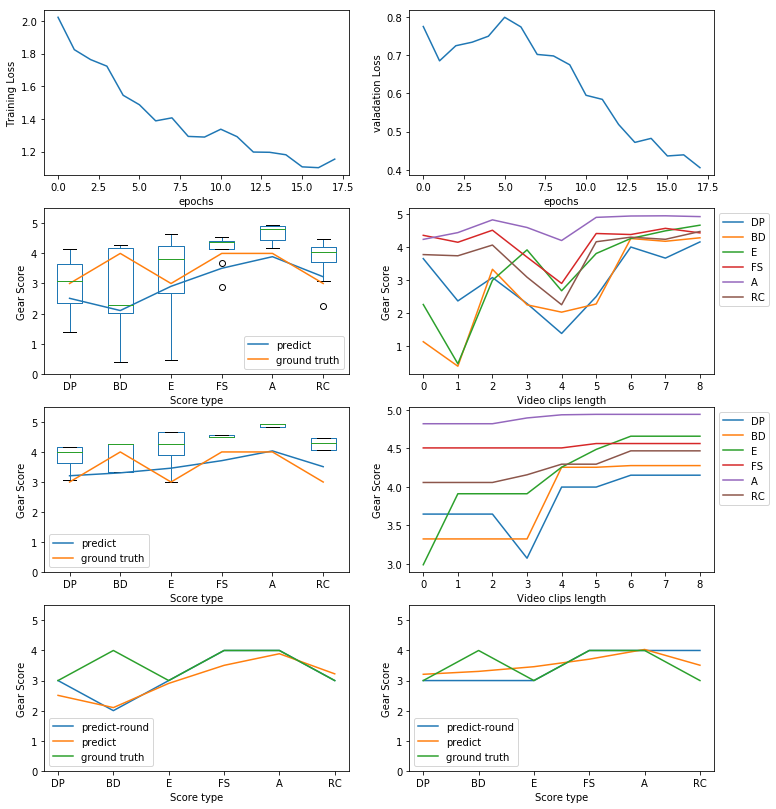

3.3126125031368727 2.197201763642073
video 49 

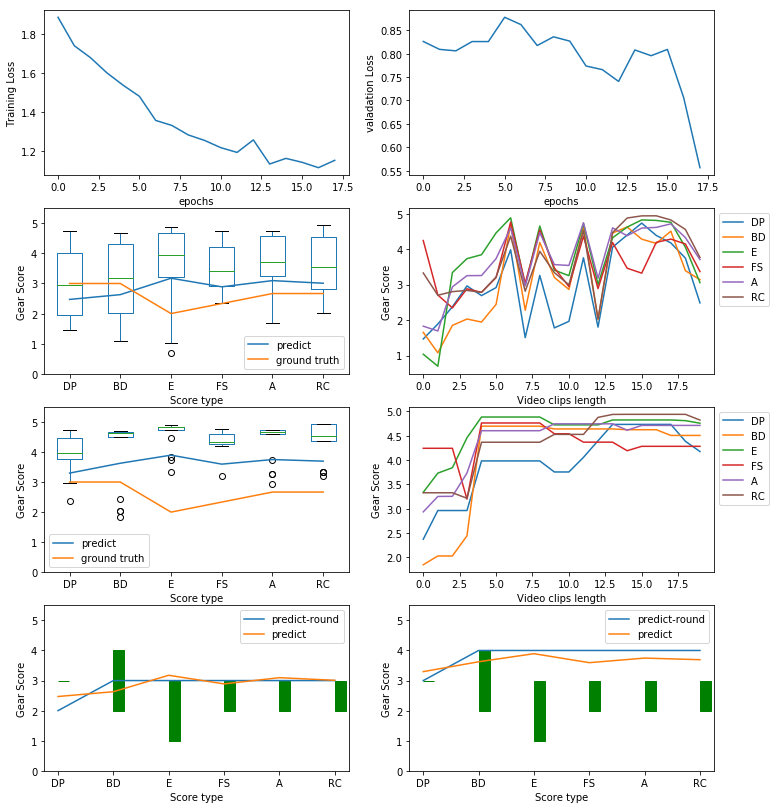

3.4030116429787234 6.183537217484957
video 59 

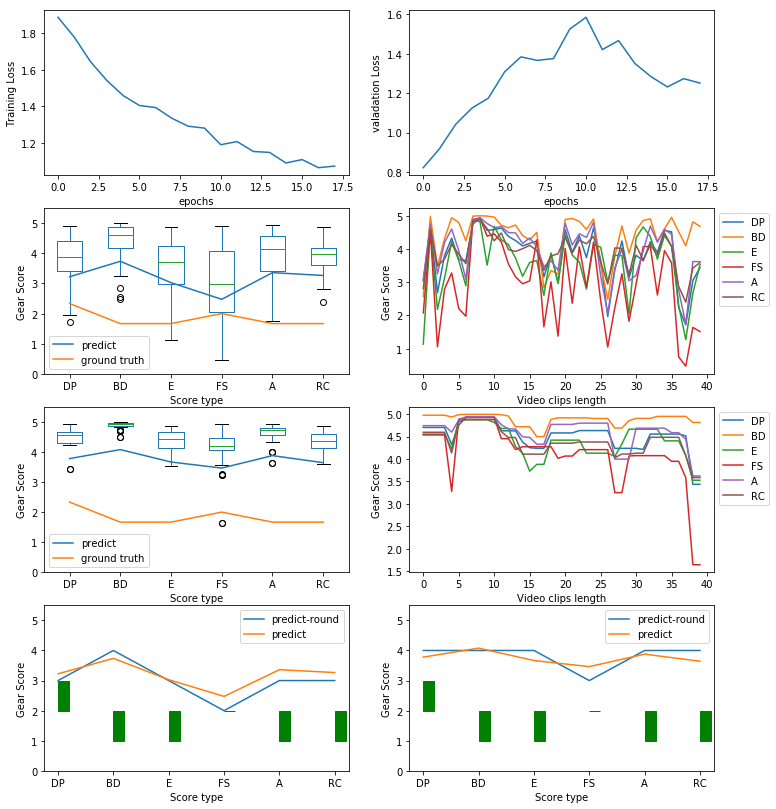

8.09167044626615 11.507231869746517
video 74 

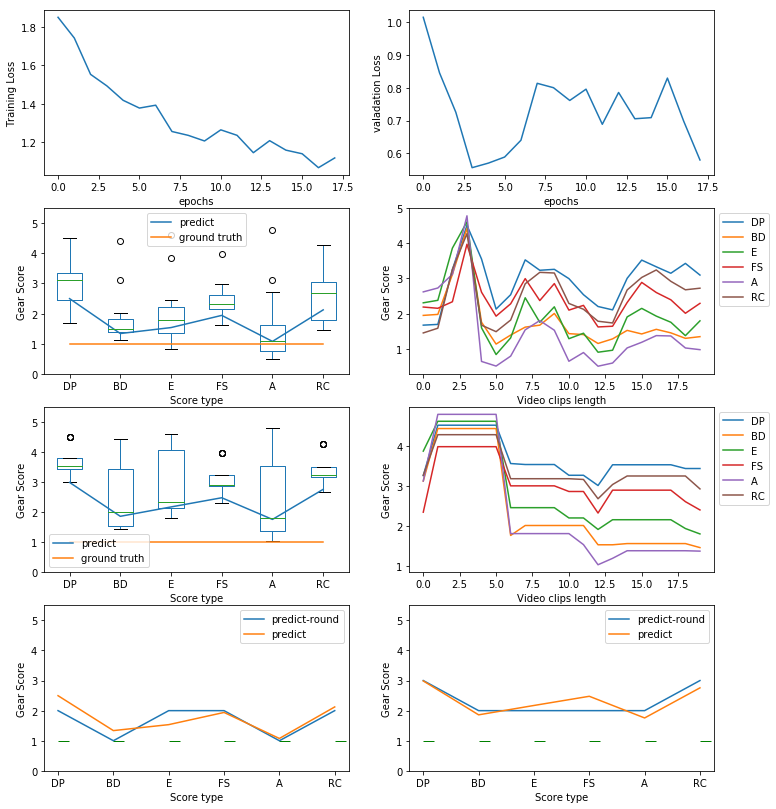

4.506520135978818 8.011065506920767
video 78 

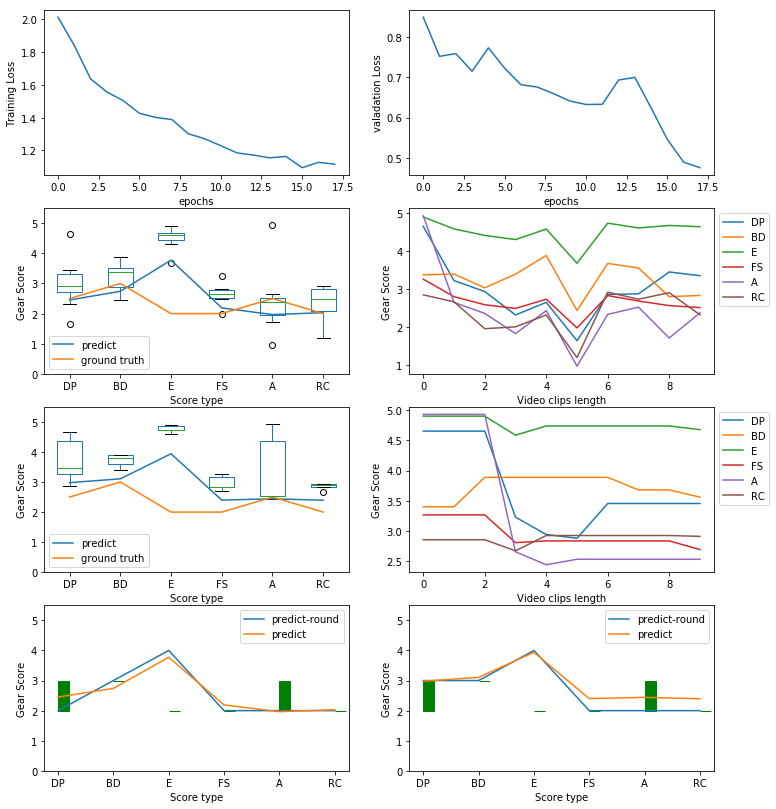

2.8375352272476673 3.376220629290676
video 91 

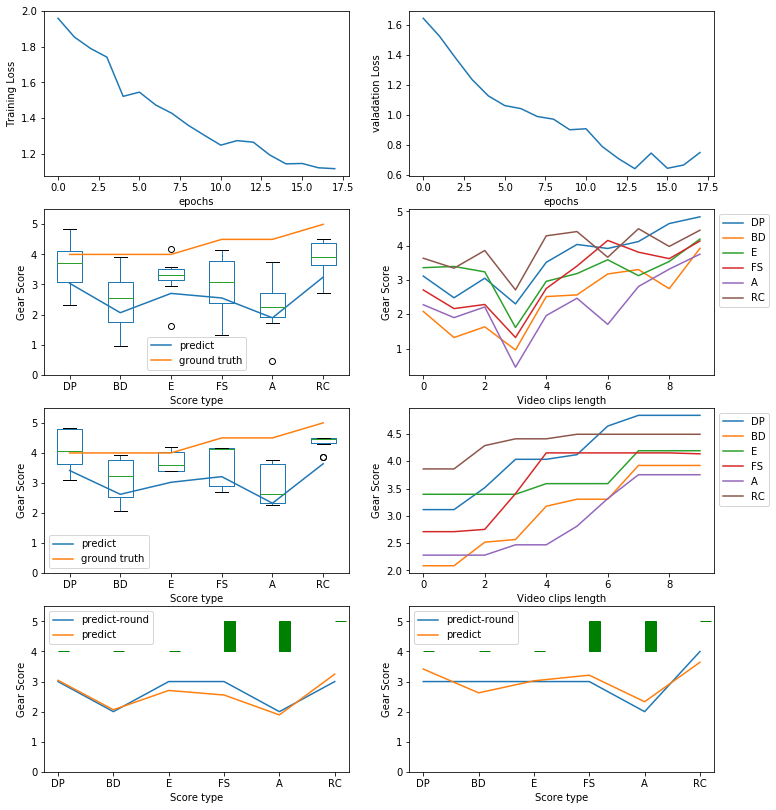

10.502021106870938 7.7512992876390445
total_loss=  15.630779772996902
all 6 gear score error DP    20.776161
BD    30.975120
E     22.892303
FS    23.447624
A     26.445712
RC    23.352779
dtype: float64


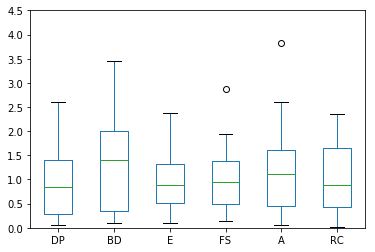

In [42]:
Diff_plot=[]
fi_Diff_plot=[]
show_result=True
E=18
l2lam=0.01
noise_range=0.1
poolingweight=[0.333333,0.333333,0.333333]
stride=1
total_loss=0
model_name='CNN'
# for i in [11, 113, 130]:
for i in Y:
    print('video',i,end=' ')
    loss,each_diff,fi_each_diff=test_hold_out(model_name,i,E,show_result,l2lam,noise_range,poolingweight,stride)
    print(np.sum(each_diff),np.sum(fi_each_diff))
    total_loss=total_loss+loss
    Diff_plot.append(each_diff)
    fi_Diff_plot.append(fi_each_diff)


Diff_plot=np.array(Diff_plot)
Diff_plot=pd.DataFrame(Diff_plot)
Diff_plot.columns = ['DP','BD','E','FS','A','RC']
Diff_plot.plot.box()
plt.ylim(0,4.5)
print('total_loss= ',total_loss)
print('all 6 gear score error',np.sum(Diff_plot))

In [43]:
ave=[6.0,
 2.0,
 1.0,
 3.0,
 8.0,
 11.333333334,
 10.0,
 11.0,
 11.0,
 5.0,
 4.0,
 3.0,
 12.0,
 8.0,
 11.0,
 11.0,
 11.0,
 3.0,
 2.333333333,
 6.999999999000002,
 12.0,
 4.0,
 8.0]

In [ ]:
model_re=Diff_plot.sum(axis=1)
model_re=list(model_re)


In [ ]:
fi_Diff_plot=np.array(fi_Diff_plot)
fi_Diff_plot=pd.DataFrame(fi_Diff_plot)
fi_model_re=fi_Diff_plot.sum(axis=1)
fi_model_re=list(fi_model_re)

In [ ]:
import os
folder='data'
for each_model in os.listdir(folder):
    name=folder+'//'+each_model

    M=np.load(name)
    M=np.sum(M)
    print(name,M)


In [ ]:
import scipy.stats as stats
import scipy
best=np.load('data//20_0.0001_0.1_0_1_0_.npy')
print('total loss of average:',np.sum(ave))
print('total loss of model:',np.sum(model_re))
print('total loss of fi_model:',np.sum(fi_model_re))
print('best model!!',np.sum(best) )

In [ ]:
best_re=np.sum(best,axis=1)
best_re=list(best_re)

In [ ]:
# F = np.var(ave) / np.var(model_re)
# alpha = 0.05 #Or whatever you want your alpha to be.
# p_value = scipy.stats.f.cdf(F, ave, model_re)
# p_value

In [ ]:
stats.f_oneway(ave,best_re)

In [ ]:
best_re

In [ ]:
ave=[6.0,
 2.0,
 1.0,
 3.0,
 8.0,
 11.333333334,
 10.0,
 11.0,
 11.0,
 5.0,
 4.0,
 3.0,
 12.0,
 8.0,
 11.0,
 11.0,
 11.0,
 3.0,
 2.333333333,
 6.999999999000002,
 12.0,
 4.0,
 8.0]

In [ ]:
run JB test
F test each score
F test for all
use raw residual 
